# Fast training with MONAI features

This tutorial shows a regular PyTorch training program and a MONAI optimized training program, and compared the performance.  
Mainly includes `AMP (Auto mixed precision)`, `CacheDataset` and `Novograd` optimizer.

With a V100 GPU, we are able to obtain approximately `12x` speedup compared with a Pytorch native implementation when the training converges at a validation mean dice of `0.93`.

It's modified from the Spleen 3D segmentation tutorial notebook, the Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb)

## Setup environment

In [2]:
%pip install -q "monai[nibabel, tqdm]"

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import math
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

from monai.config import get_torch_version_tuple
from monai.data import Dataset, CacheDataset, SmartCacheDataset, DataLoader
from monai.transforms import Compose, LoadNiftid, AddChanneld, \
    ScaleIntensityRanged, CropForegroundd, FgBgToIndicesd, ToTensord, \
    RandCropByPosNegLabeld, DeleteItemsd, Spacingd, Orientationd
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.optimizers import Novograd
from monai.metrics import compute_meandice
from monai.utils import set_determinism
from monai.config import print_config
from monai.apps import download_and_extract

print_config()

if get_torch_version_tuple() < (1, 6):
    raise RuntimeError('AMP feature only exists in PyTorch version greater than v1.6.')

MONAI version: 0.2.0+165.g72df264
Python version: 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21)  [GCC 7.3.0]
Numpy version: 1.19.1
Pytorch version: 1.7.0a0+8deb4fe

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.1
scikit-image version: 0.15.0
Pillow version: 7.2.0
Tensorboard version: 1.15.0+nv
gdown version: 3.12.2
TorchVision version: 0.8.0a0
ITK version: 5.1.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
import tempfile

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [3]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [4]:
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [5]:
def transformations():
    train_transforms = Compose([
        LoadNiftid(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        # pre-compute foreground and background indexes and cache them to accelerate training
        FgBgToIndicesd(keys="label", fg_postfix="_fg", bg_postfix="_bg",image_key="image"),
        # randomly crop out patch samples from big image based on pos / neg ratio
        # the image centers of negative samples must be in valid image area
        RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(128, 128, 96), pos=1,
                               neg=1, num_samples=4, fg_indices_key="label_fg", bg_indices_key="label_bg"),
        DeleteItemsd(keys=["label_fg", "label_bg"]),
        ToTensord(keys=['image', 'label'])
    ])
    val_transforms = Compose([
        LoadNiftid(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        ToTensord(keys=['image', 'label'])
    ])
    return train_transforms, val_transforms

## Define the training progress
For a typical PyTorch regular training procedure, use regular `Dataset`, `Adam` optimizer, and train the model.

For MONAI fast training progress, we mainly introduce the following features:
1. `CacheDataset`: Dataset with the cache mechanism that can load data and cache deterministic transforms' result during training.
2. `Novograd` optimizer: Novograd is based on the paper "Stochastic Gradient Methods with Layer-wise Adaptive Moments for Training of Deep Networks" `<https://arxiv.org/pdf/1905.11286.pdf>`.
3. `AMP` (auto mixed precision): AMP is an important feature released in PyTorch v1.6, NVIDIA CUDA 11 added strong support for AMP and significantly improved training speed.

In [6]:
def train_process(fast=False):
    epoch_num = 300
    learning_rate = 1e-4
    val_interval = 1  # do validation for every epoch

    train_trans, val_trans = transformations()
    # set CacheDataset for MONAI training
    if fast:
        train_ds = CacheDataset(data=train_files, transform=train_trans, cache_rate=1.0, num_workers=8)
        val_ds = CacheDataset(data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5)
        # don't need many workers because already cached the data
        loader_workers = 1
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        loader_workers = 4

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=loader_workers)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=loader_workers)

    device = torch.device('cuda:0')
    model = UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)

    # set Novograd optimizer for MONAI training
    if fast:
        # Novograd paper suggests to use a bigger LR than Adam,
        # because Adam does normalization by element-wise second moments
        optimizer = Novograd(model.parameters(), learning_rate * 10)
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = list()
    metric_values = list()
    epoch_times = list()
    total_start = time.time()
    for epoch in range(epoch_num):
        epoch_start = time.time()
        print('-' * 10)
        print(f"epoch {epoch + 1}/{epoch_num}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
            optimizer.zero_grad()
            # set AMP for MONAI training
            if fast:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                  f" step time: {(time.time() - step_start):.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                metric_sum = 0.
                metric_count = 0
                for val_data in val_loader:
                    val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                    roi_size = (160, 160, 128)
                    sw_batch_size = 4
                    # set AMP for MONAI validation
                    if fast:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    else:
                        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                             to_onehot_y=True, mutually_exclusive=True)
                    metric_count += len(value)
                    metric_sum += value.sum().item()
                metric = metric_sum / metric_count
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(time.time() - total_start)
                    torch.save(model.state_dict(), 'best_metric_model.pth')
                    print('saved new best metric model')
                print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                      f" best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")
        print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
        epoch_times.append(time.time() - epoch_start)

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}"
          f" total time: {(time.time() - total_start):.4f}")
    return epoch_num, epoch_loss_values, metric_values, epoch_times, best_metrics_epochs_and_time

## Enable determinism and execute regular PyTorch training

In [ ]:
set_determinism(seed=0)
regular_start = time.time()
epoch_num, epoch_loss_values, metric_values, epoch_times, best = train_process(fast=False)
total_time = time.time() - regular_start
print(f"total training time of {epoch_num} epochs with regular PyTorch: {total_time:.4f}")

## Enable determinism and execute MONAI optimized training

In [ ]:
set_determinism(seed=0)
monai_start = time.time()
epoch_num, m_epoch_loss_values, m_metric_values, m_epoch_times, m_best = train_process(fast=True)
m_total_time = time.time() - monai_start
print(f"total training time of {epoch_num} epochs with MONAI: {m_total_time:.4f}")

## Plot training loss and validation metrics

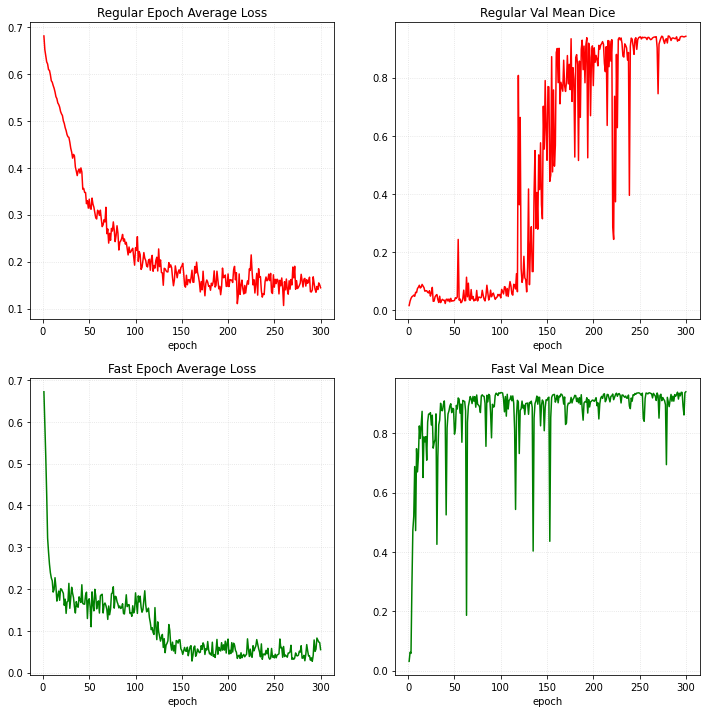

In [12]:
plt.figure('train', (12, 12))
plt.subplot(2, 2, 1)
plt.title('Regular Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(2, 2, 2)
plt.title('Regular Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(2, 2, 3)
plt.title('Fast Epoch Average Loss')
x = [i + 1 for i in range(len(m_epoch_loss_values))]
y = m_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')

plt.subplot(2, 2, 4)
plt.title('Fast Val Mean Dice')
x = [i + 1 for i in range(len(m_metric_values))]
y = m_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')
plt.show()

## Plot total time and every epoch time

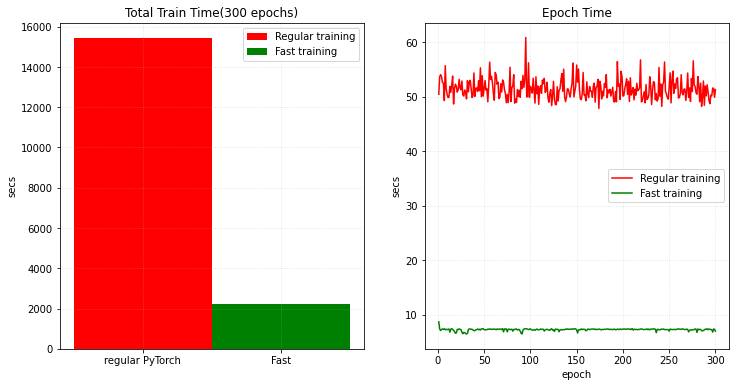

In [13]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Total Train Time(300 epochs)')
plt.bar('regular PyTorch', total_time, 1, label='Regular training', color='red')
plt.bar('Fast', m_total_time, 1, label='Fast training', color='green')
plt.ylabel('secs')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Epoch Time')
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel('epoch')
plt.ylabel('secs')
plt.plot(x, epoch_times, label='Regular training', color='red')
plt.plot(x, m_epoch_times, label='Fast training', color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')
plt.show()

## Plot total time to achieve metrics

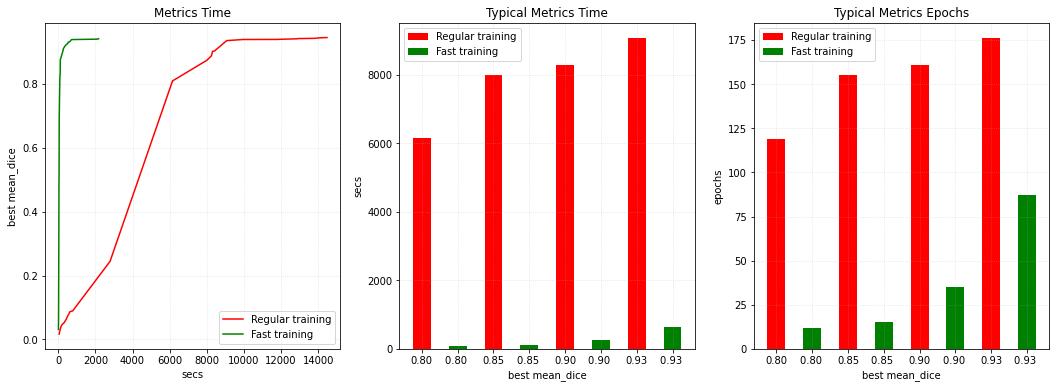

In [14]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[2][i]
    return -1

def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if v > threshold:
            return best_values[1][i]
    return -1

plt.figure('train', (18, 6))
plt.subplot(1, 3, 1)
plt.title('Metrics Time')
plt.xlabel('secs')
plt.ylabel('best mean_dice')
plt.plot(best[2], best[0], label='Regular training', color='red')
plt.plot(m_best[2], m_best[0], label='Fast training', color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.title('Typical Metrics Time')
plt.xlabel('best mean_dice')
plt.ylabel('secs')
plt.bar("0.80", get_best_metric_time(0.8, best), 0.5, label='Regular training', color='red')
plt.bar("0.80 ", get_best_metric_time(0.8, m_best), 0.5, label='Fast training', color='green')
plt.bar("0.85", get_best_metric_time(0.85, best), 0.5, color='red')
plt.bar("0.85 ", get_best_metric_time(0.85, m_best), 0.5, color='green')
plt.bar("0.90", get_best_metric_time(0.9, best), 0.5, color='red')
plt.bar("0.90 ", get_best_metric_time(0.9, m_best), 0.5, color='green')
plt.bar("0.93", get_best_metric_time(0.93, best), 0.5, color='red')
plt.bar("0.93 ", get_best_metric_time(0.93, m_best), 0.5, color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')

plt.subplot(1, 3, 3)
plt.title('Typical Metrics Epochs')
plt.xlabel('best mean_dice')
plt.ylabel('epochs')
plt.bar("0.80", get_best_metric_epochs(0.8, best), 0.5, label='Regular training', color='red')
plt.bar("0.80 ", get_best_metric_epochs(0.8, m_best), 0.5, label='Fast training', color='green')
plt.bar("0.85", get_best_metric_epochs(0.85, best), 0.5, color='red')
plt.bar("0.85 ", get_best_metric_epochs(0.85, m_best), 0.5, color='green')
plt.bar("0.90", get_best_metric_epochs(0.9, best), 0.5, color='red')
plt.bar("0.90 ", get_best_metric_epochs(0.9, m_best), 0.5, color='green')
plt.bar("0.93", get_best_metric_epochs(0.93, best), 0.5, color='red')
plt.bar("0.93 ", get_best_metric_epochs(0.93, m_best), 0.5, color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)